In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch as th
from pytorch_lightning import seed_everything

from tint.datasets import Arma

SEED = 42
seed_everything(seed=SEED, workers=True)

Seed set to 42


42

In [11]:
arma = Arma(seed=SEED)
arma.download()  # This method generates the dataset
inputs = arma.preprocess()["x"]
true_saliencies = arma.true_saliency(dim=1)

In [4]:
import pickle

def save_explainer(explainer, mlp=None, explainer_name="explainer"):
    if mlp is not None:
        with open(f"mlp_{explainer_name}.pkl", "wb") as f:
            pickle.dump(mlp, f)

    with open(f"{explainer_name}.pkl", "wb") as f:
        pickle.dump(explainer, f)


def load_explainer(explainer_name="explainer"):
    with open(f"{explainer_name}_attr.pkl", "rb") as f:
        attr = pickle.load(f)       

    with open(f"{explainer_name}_mask_net.pkl", "rb") as f:
        mask_net = pickle.load(f)     

    with open(f"{explainer_name}_explainer.pkl", "rb") as f:
        ecl_inputsplainer = pickle.load(f)     

    return attr, mask_net, ecl_inputsplainer

In [5]:
extremal_attr, extremal_mask_net, extremal_explainer = load_explainer("experiments/arma/extremal")

In [6]:
# Taken from https://github.com/fzi-forschungszentrum-informatik/TSInterpret/blob/main/TSInterpret/InterpretabilityModels/Saliency/Saliency_Base.py
def plot_saliency(ts_data, perturbed, saliency_list, figsize=None):
    if figsize is None:
        figsize = (10, len(ts_data)*1.2)
    ax011 = []
    i = 0

    fig, axn = plt.subplots(
        len(ts_data), 1, sharex=True, sharey=True, figsize=figsize
    )
    cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])

    for channel in ts_data:
        # print(ts_data.shape)
        # ax011.append(plt.subplot(len(ts_data[0]),1,i+1))
        # ax012.append(ax011[i].twinx())
        # ax011[i].set_facecolor("#440154FF")
        axn012 = axn[i].twinx()

        # Plot saliency
        sns.heatmap(
            saliency_list[i].reshape(1, -1),
            fmt="g",
            cmap="viridis",
            cbar=i == 0,
            cbar_ax=None if i else cbar_ax,
            ax=axn[i],
            yticklabels=False,
            vmin=0,
            vmax=1,
        )
        # Plot original data
        sns.lineplot(
            x=range(0, len(channel.reshape(-1))),
            y=channel.flatten(),
            ax=axn012,
            color="white",
        )
        # Plot learned perturbations
        sns.lineplot(
            x=range(0, len(channel.reshape(-1))),
            # The perturbation comes from an NN, need to detach it
            y=perturbed[i].detach().numpy(),
            ax=axn012,
            color="red",
        )
        plt.xlabel("Time", fontweight="bold", fontsize="large")
        plt.ylabel(f"Feature {i}", fontweight="bold", fontsize="large")
        i = i + 1
    fig.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

In [7]:
# Taken from https://github.com/fzi-forschungszentrum-informatik/TSInterpret/blob/main/TSInterpret/InterpretabilityModels/Saliency/Saliency_Base.py
def plot_saliency2(saliencies, figsize=None):
    N = len(saliencies)
    if figsize is None:
        figsize = (10, N * 2)

    fig, axn = plt.subplots(
        int(np.ceil(N / 2)), 2, sharex=True, sharey=True, figsize=figsize
    )
    axn = axn.flatten()
    cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])

    color_map = sns.diverging_palette(10, 133, as_cmap=True)

    for idx, (method, saliency) in enumerate(saliencies.items()):
        sns.heatmap(
            saliency,
            cmap=color_map,
            cbar=idx == 0,
            cbar_ax=None if idx else cbar_ax,
            cbar_kws={"label": "Mask"},
            ax=axn[idx],
            yticklabels=False,
            linecolor="#d8cbd5",
            linewidths=0.4,
            vmin=0,
            vmax=1,
        )
        axn[idx].set_title(f"Method: {method}")
        axn[idx].set_xlabel("Time")
        axn[idx].set_ylabel("Feature number")
        
    fig.suptitle("Mask coefficients over time")
    fig.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

In [ ]:
SAL_ID = 0
saliencies = {
    "true": true_saliencies[SAL_ID],
    "extremal": extremal_attr[SAL_ID],
}
plot_saliency2(saliencies)

In [33]:
batch_size = 50  # Network was trained with this
sample_id = 0  # Take the first data sample
batch_idx = sample_id // batch_size
FROM_B = batch_idx * batch_size
TO_B = batch_idx * batch_size + batch_size
x = inputs[FROM_B:TO_B]
print(x.size())
# Create a baseline for each time series in a sample
# The baseline is a mean, computed for each time series
# baseline = th.ones_like(x) * th.mean(x, axis=1).reshape(-1, 1)
baseline = th.zeros_like(x)
target = None
additional_forward_args = (true_saliencies[FROM_B:TO_B],)

torch.Size([50, 50, 50])


In [35]:
# Get perturbed output
# y_hat1 is computed by masking important features
# y_hat2 is computed by masking unimportant features
yhat1, yhat2 = extremal_mask_net(x.float(), batch_idx, baseline, target, *additional_forward_args)
yhat1.size()

torch.Size([50, 50])

In [36]:
from captum._utils.common import _run_forward
# Get unperturbed output for inputs and baselines
y_target1 = _run_forward(
    forward_func=extremal_mask_net.net.forward_func,
    inputs=x,
    target=target,
    additional_forward_args=additional_forward_args
)
y_target1.size()

torch.Size([50, 50])

In [57]:
plt.style.use("ggplot")

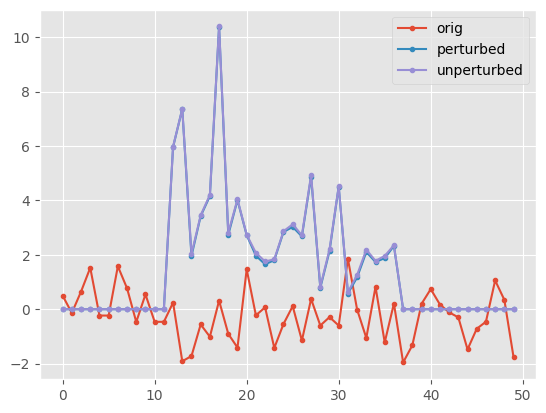

In [58]:
xs = np.arange(len(x[0][0]))
plt.plot(xs, x[0][0], marker=".", label="orig")
plt.plot(xs, yhat1[0].detach(), marker=".", label="perturbed")
plt.plot(xs, y_target1[0].detach(), marker=".", label="unperturbed")
plt.legend()
plt.show()

In [ ]:
# TODO:
# Align batches to visualize correct data
# Is the 0 baseline correct?
# instead of mask, visualize the metric by Jiapeng (metric for determining salient features)
# visualize: original, background, mask, perturbed = m * x + (1 - m) * background

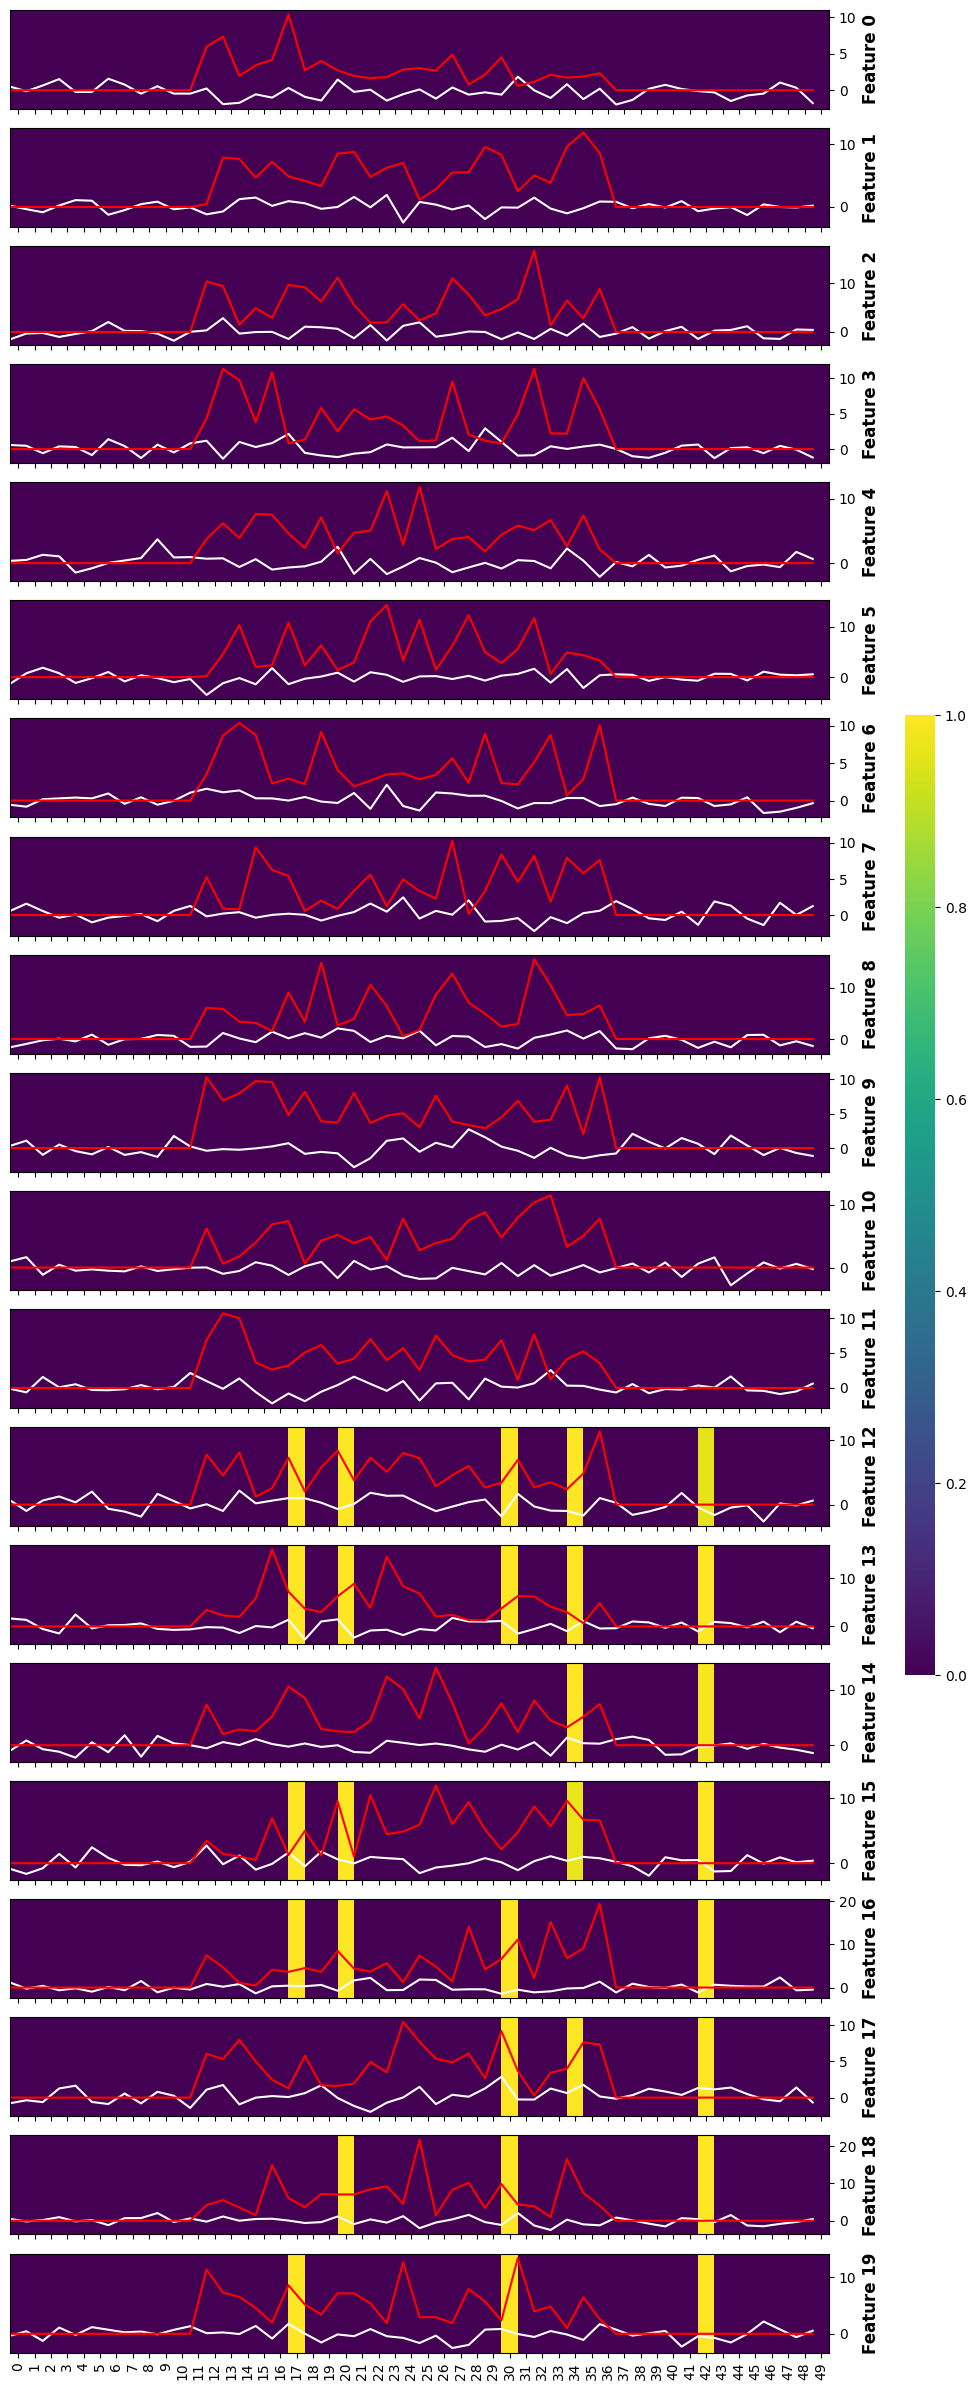

In [46]:
FROM = 0
TO = 20
plot_saliency(x[sample_id][FROM:TO], yhat1[FROM:TO], extremal_attr[sample_id][FROM:TO])

In [ ]:
# batch_size = extremal_mask_net.net.batch_size
batch_size = x.size()[0]
batch_idx = 1

mask = extremal_mask_net.net.mask
print(mask.size())
mask = mask[
    batch_size * batch_idx : batch_size * (batch_idx + 1)
]

mask = mask.clamp(0, 1)
mask = mask[:, : x.shape[1], ...]
print(x.size())
print(mask.size())
print(baseline.size())
x1 = x * mask + baseline * (1.0 - mask)
x2 = x * (1.0 - mask) + baseline * mask


In [ ]:
FROM = 0
TO = 20
plot_saliency(inputs[0][FROM:TO], yhat1[FROM:TO], extremal_attr[0][FROM:TO])

In [ ]:
FROM = 0
TO = 20
plot_saliency(inputs[0][FROM:TO], x1[0][FROM:TO], true_saliencies[0][FROM:TO])

In [ ]:
idx = 14
plt.plot(np.arange(len(inputs[0][idx])), inputs[0][idx], label="orig", marker=".")
plt.plot(np.arange(len(inputs[0][idx])), x1[0][idx].detach().numpy(), marker=".", label="perturbed")
plt.legend()
plt.show()

In [ ]:
import random
import torch as th

from captum.attr import (
    IntegratedGradients,
    FeaturePermutation,
    ShapleyValueSampling,
)
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger

from tint.attr import (
    DynaMask,
    ExtremalMask,
    Occlusion,
)
from tint.attr.models import ExtremalMaskNet, MaskNet

def train_dynamask(x, true_saliency, max_epochs=1000, device="cpu", device_id=1, deterministic=False):
    trainer = Trainer(
        max_epochs=max_epochs,
        # accelerator=accelerator,
        devices=device_id,
        deterministic=deterministic,
        logger=TensorBoardLogger(
            save_dir=".",
            version=random.getrandbits(128),
        ),
    )
    mask = MaskNet(
        forward_func=arma.get_white_box,
        perturbation="gaussian_blur",
        keep_ratio=list(np.arange(0.001, 0.051, 0.001)),
        size_reg_factor_init=1,
        size_reg_factor_dilation=1000,
        optim="adam",
        lr=0.001,
    )
    explainer = DynaMask(arma.get_white_box)
    _attr = explainer.attribute(
        x,
        trainer=trainer,
        mask_net=mask,
        batch_size=50,
        additional_forward_args=(true_saliency,),
        return_best_ratio=True,
    )
    print(f"Best keep ratio is {_attr[1]}")
    return _attr[0]

def train_extremal_mask(x, true_saliency, max_epochs=2000, device="cpu", device_id=1, deterministic=False):
    trainer = Trainer(
        max_epochs=max_epochs,
        # accelerator=accelerator,
        devices=device_id,
        log_every_n_steps=2,
        deterministic=deterministic,
        logger=TensorBoardLogger(
            save_dir=".",
            version=random.getrandbits(128),
        ),
    )
    mask = ExtremalMaskNet(
        forward_func=arma.get_white_box,
        optim="adam",
        lr=0.01,
    )
    explainer = ExtremalMask(arma.get_white_box)
    _attr = explainer.attribute(
        x,
        trainer=trainer,
        mask_net=mask,
        batch_size=50,
        additional_forward_args=(true_saliency,),
    )
    return _attr

def train_integrated_gradients(x, true_saliency):
    attr = th.zeros_like(x)
    for i, (inputs, saliency) in enumerate(zip(x, true_saliency)):
        explainer = IntegratedGradients(forward_func=arma.get_white_box)
        baseline = inputs * 0
        attr[i] = explainer.attribute(
            inputs,
            baselines=baseline,
            additional_forward_args=(saliency,),
        ).abs()

    return attr

def train_occlusion(x, true_saliency):
    attr = th.zeros_like(x)
    for i, (inputs, saliency) in enumerate(zip(x, true_saliency)):
        explainer = Occlusion(forward_func=arma.get_white_box)
        baseline = th.mean(inputs, dim=0, keepdim=True)
        attr[i] = explainer.attribute(
            inputs,
            sliding_window_shapes=(1,),
            baselines=baseline,
            additional_forward_args=(saliency,),
        ).abs()
    return attr

def train_permutation(x, true_saliency):
    attr = th.zeros_like(x)
    for i, (inputs, saliency) in enumerate(zip(x, true_saliency)):
        explainer = FeaturePermutation(forward_func=arma.get_white_box)
        attr[i] = explainer.attribute(
            inputs,
            additional_forward_args=(saliency,),
        ).abs()
    return attr

def train_shapley_values(x, true_saliency):
    attr = th.zeros_like(x)
    for i, (inputs, saliency) in enumerate(zip(x, true_saliency)):
        explainer = ShapleyValueSampling(forward_func=arma.get_white_box)
        baseline = th.mean(inputs, dim=0, keepdim=True)
        attr[i] = explainer.attribute(
            inputs,
            baselines=baseline,
            additional_forward_args=(saliency,),
        ).abs()
    return attr

## Extremal Mask

In [ ]:
import torch
from tint.attr import ExtremalMask
from tint.models import MLP

# Init prediction model
mlp = MLP([inputs.size()[2], 3, 1])

# Init explainability models
extremal_explainer = ExtremalMask(mlp)

In [ ]:
inputs.size()

In [ ]:
trainer = Trainer(
    max_epochs=500,
    # accelerator=accelerator,
    devices=1,
    log_every_n_steps=2,
    deterministic=False,
    logger=TensorBoardLogger(
        save_dir=".",
        version=random.getrandbits(128),
    ),
)
mask = ExtremalMaskNet(
    forward_func=arma.get_white_box,
    optim="adam",
    lr=0.01,
)
explainer = ExtremalMask(arma.get_white_box)
_attr = explainer.attribute(
    inputs,
    trainer=trainer,
    mask_net=mask,
    batch_size=50,
    additional_forward_args=(true_saliencies,),
)

In [ ]:
attr_extremal, extrmask_net, extremal_explainer = train_extremal_mask(inputs, true_saliencies, max_epochs=500)
save_explainer(attr_extremal, explainer_name="extremal_attr")
save_explainer(extrmask_net, explainer_name="extremal_mask_net")
save_explainer(extremal_explainer, explainer_name="extremal_explainer")

In [ ]:
mask_net.forward(inputs[0])
mask_net

In [ ]:
# Fit explainer on inputs given the MLP
attr_extremal = extremal_explainer.attribute(inputs)
save_explainer(attr_extremal, mlp, explainer_name="extremal")

In [ ]:
from tint.metrics.white_box import aup, aur, rmse

print(f"AUP: {aup(attr_extremal, true_saliencies):.4}")
print(f"AUR: {aur(attr_extremal, true_saliencies):.4}")
print(f"RMSE: {rmse(attr_extremal, true_saliencies):.4}")

In [ ]:
plot_saliency(inputs[0], attr_extremal[0])

In [ ]:
SAL_ID = 20
saliencies = {
    "true": true_saliencies[SAL_ID],
    "extremal": attr_extremal[SAL_ID],
}
plot_saliency2(saliencies)

## Dynamic Mask

In [ ]:
attr_dynamask, dynamask_net, dynamask_explainer = train_dynamask(inputs, true_saliencies, max_epochs=500)
save_explainer(attr_extremal, explainer_name="attr_dynamask")
save_explainer(mask_net, explainer_name="dynamask_net")
save_explainer(explainer, explainer_name="dynamask_explainer")

In [ ]:
import torch
from tint.attr import DynaMask
from tint.models import MLP

# Init prediction model
mlp = MLP([inputs.size()[2], 3, 1])

# Init explainability models
dynamask_explainer = DynaMask(mlp)

In [ ]:
attr_dynamask = dynamask_explainer.attribute(inputs)
save_explainer(attr_dynamask, mlp, explainer_name="dynamask")

In [ ]:
print(f"AUP: {aup(attr_dynamask, true_saliencies):.4}")
print(f"AUR: {aur(attr_dynamask, true_saliencies):.4}")
print(f"RMSE: {rmse(attr_dynamask, true_saliencies):.4}")

In [ ]:
plot_saliency(inputs[0], attr_dynamask[0])

## Temporal Integrated Gradient

In [ ]:
import torch
from tint.attr import TemporalIntegratedGradients
from tint.models import MLP

# Init prediction model
mlp = MLP([inputs.size()[2], 3, 1])

# Init explainability models
tig_explainer = TemporalIntegratedGradients(mlp)

In [ ]:
attr_tig = tig_explainer.attribute(inputs, target=0)
save_explainer(attr_tig, mlp, explainer_name="tig")

In [ ]:
print(f"AUP: {aup(attr_tig, true_saliencies):.4}")
print(f"AUR: {aur(attr_tig, true_saliencies):.4}")
print(f"RMSE: {rmse(attr_tig, true_saliencies):.4}")

In [ ]:
plot_saliency(inputs[0], attr_tig[0])